In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from calendar import monthrange

In [49]:
df = pd.read_csv('Complaint_Unemployed.csv')
df.rename(columns = {'CMPLNT_FR_DT': 'Month', 'unem_r': 'Unem_R'}, inplace=True)
df.Month = pd.to_datetime(
    df.Month, errors='coerce', infer_datetime_format = True)
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.set_index('Month', inplace = True)

In [50]:
df_weather = pd.read_csv('API weather Data/df_combined.csv')
df_weather.Date = pd.to_datetime(
    df_weather.Date, errors='coerce', infer_datetime_format = True)
df_weather.set_index('Date', inplace = True)

In [51]:
df_weather.head()

,High_Temp
Date,
2006-01-01,39.72
2006-01-02,44.15
2006-01-03,36.20
2006-01-04,36.66
2006-01-05,48.62


In [52]:
df_weather_mean = df_weather.resample('MS').mean()

In [53]:
df_weather_mean.rename(columns = {'High_Temp': 'Mean_Temp'}, inplace=True)

In [54]:
df_weather_mean.head()

,Mean_Temp
Date,
2006-01-01,45.033226
2006-02-01,40.423214
2006-03-01,49.034516
2006-04-01,62.382333
2006-05-01,69.665806


In [55]:
df_weather_over70 = df_weather[df_weather.High_Temp >= 70].resample('MS').count()

In [56]:
df_weather_over70.rename(columns = {'High_Temp': 'Over70'}, inplace=True)

In [57]:
df_weather_over70.head()

,Over70
Date,
2006-03-01,1
2006-04-01,7
2006-05-01,12
2006-06-01,22
2006-07-01,31


In [66]:
days_in_month = {}
for year in range(2006,2019):
    for mo in range(1,13):
        days = monthrange(year, mo)[1]

        if mo < 10:
            month = '0'+ str(mo)
        else:
            month = str(mo)
        dict_key = str(year) + '-' + month + '-' + '01'
        value = days

        days_in_month[dict_key] = value

days_df =  pd.DataFrame.from_dict(days_in_month, orient='index')

In [75]:
days_df.rename(columns = {days_df.columns[0]: 'Days'}, inplace=True)
days_df.index = pd.to_datetime(
    days_df.index, errors='coerce', infer_datetime_format = True)

In [76]:
days_df.index

DatetimeIndex(['2006-01-01', '2006-02-01', '2006-03-01', '2006-04-01',
               '2006-05-01', '2006-06-01', '2006-07-01', '2006-08-01',
               '2006-09-01', '2006-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', length=156, freq=None)

In [77]:
completed_df = df.join([df_weather_mean, df_weather_over70, days_df]).fillna(0)

In [84]:
completed_df.head()

,Count,Unem_R,Mean_Temp,Over70,Days
Month,,,,,
2006-01-01,16392,5.1,45.033226,0.0,31
2006-02-01,13101,5.3,40.423214,0.0,28
2006-03-01,15572,5.0,49.034516,1.0,31
2006-04-01,15123,4.6,62.382333,7.0,30
2006-05-01,16679,4.5,69.665806,12.0,31


In [79]:
completed_df.to_csv('final.csv')

In [90]:
diff_unem = completed_df.Unem_R.diff().dropna()

In [91]:
diff_over70 = completed_df.Over70.diff().dropna()

In [92]:
diff_mean_temp = completed_df.Mean_Temp.diff().dropna()

In [94]:
diff_days = completed_df.Days.diff().dropna()

In [102]:
diff_unem2 = diff_unem.diff().dropna()

In [4]:
#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(20, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

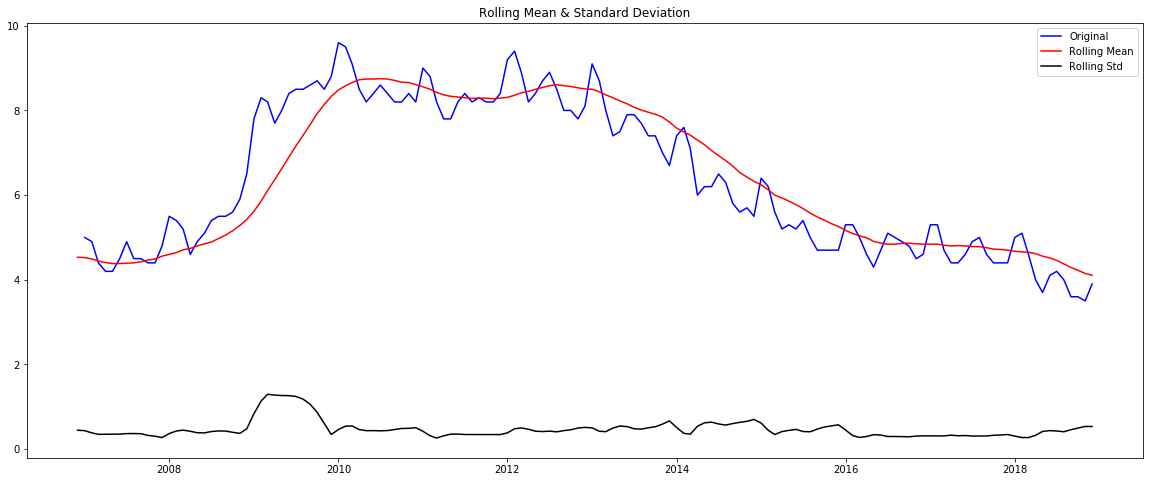

Results of Dickey-Fuller Test:
Test Statistic                  -2.081113
p-value                          0.252177
#Lags Used                      12.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


In [89]:
test_stationarity(completed_df.Unem_R, 12)

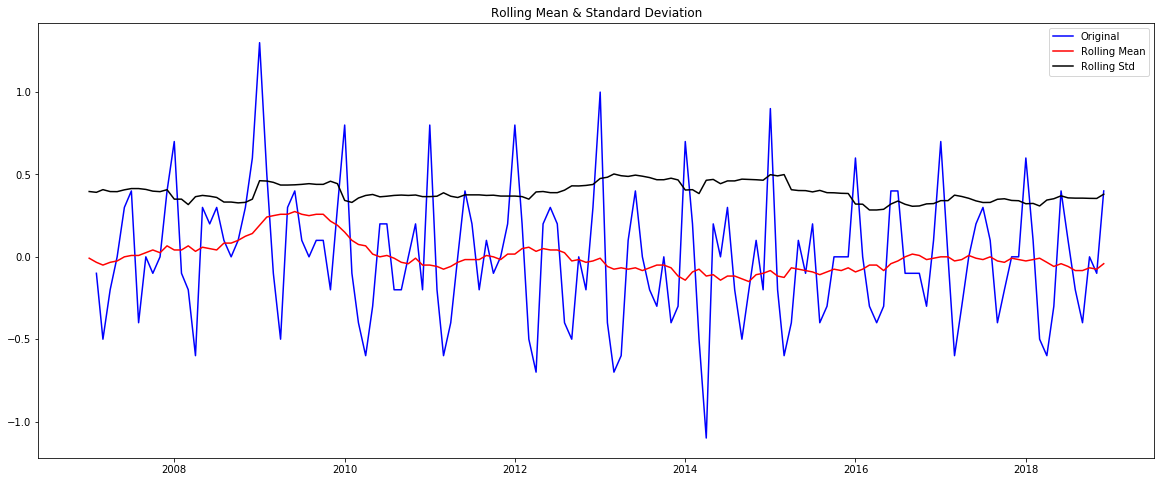

Results of Dickey-Fuller Test:
Test Statistic                  -1.635538
p-value                          0.464593
#Lags Used                      11.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


In [95]:
test_stationarity(diff_unem, 12)

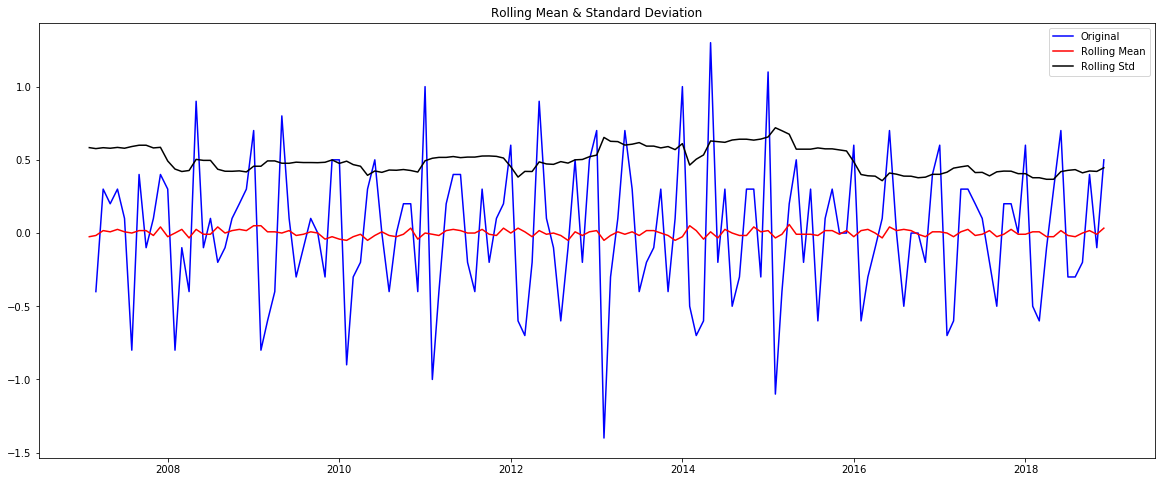

Results of Dickey-Fuller Test:
Test Statistic                -1.020864e+01
p-value                        5.715462e-18
#Lags Used                     1.000000e+01
Number of Observations Used    1.430000e+02
Critical Value (1%)           -3.476927e+00
Critical Value (5%)           -2.881973e+00
Critical Value (10%)          -2.577665e+00
dtype: float64


In [103]:
test_stationarity(diff_unem2, 12)

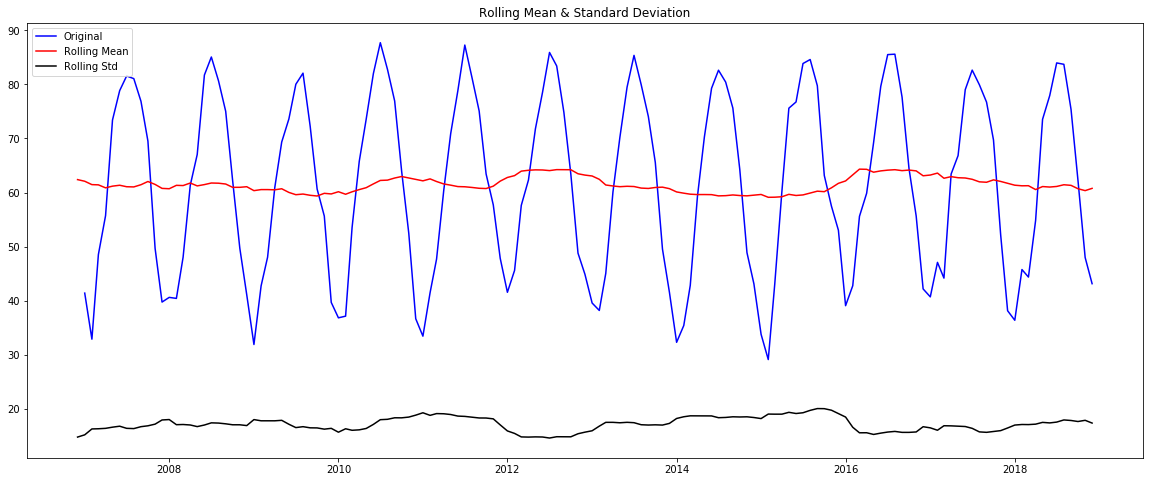

Results of Dickey-Fuller Test:
Test Statistic                  -2.587348
p-value                          0.095640
#Lags Used                      10.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64


In [96]:
test_stationarity(completed_df.Mean_Temp, 12)

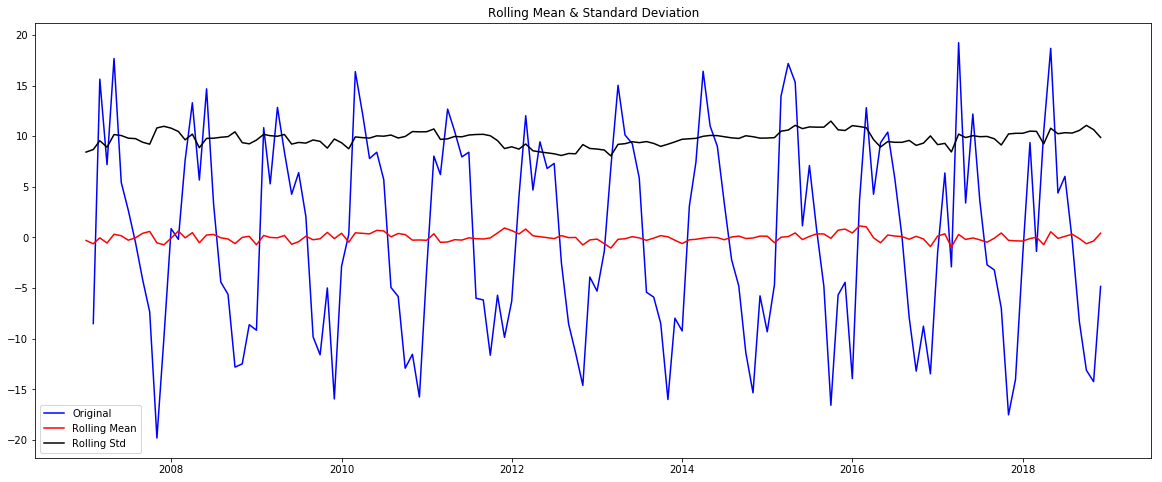

Results of Dickey-Fuller Test:
Test Statistic                -1.143310e+01
p-value                        6.444557e-21
#Lags Used                     9.000000e+00
Number of Observations Used    1.450000e+02
Critical Value (1%)           -3.476273e+00
Critical Value (5%)           -2.881688e+00
Critical Value (10%)          -2.577513e+00
dtype: float64


In [97]:
test_stationarity(diff_mean_temp, 12)

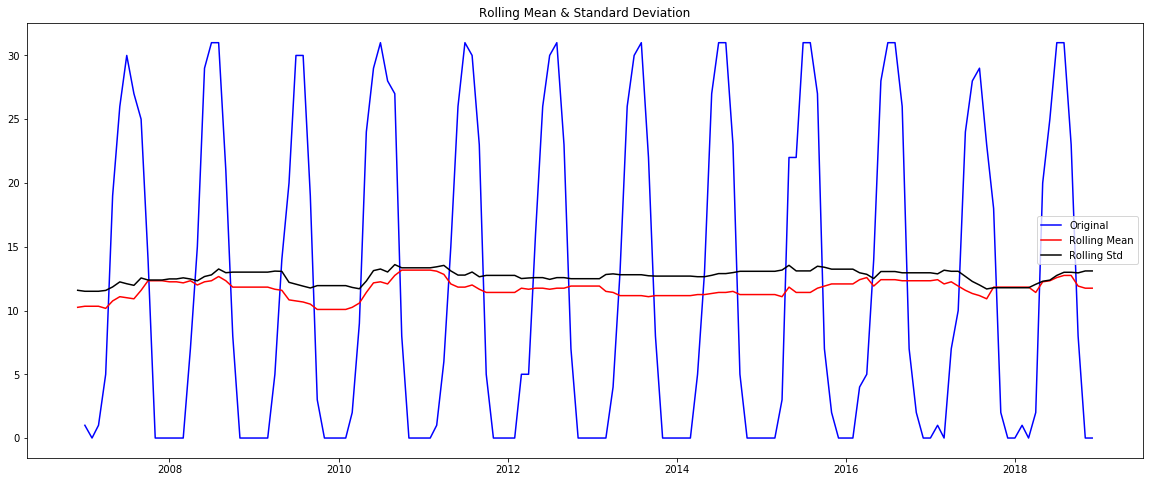

Results of Dickey-Fuller Test:
Test Statistic                  -3.694454
p-value                          0.004192
#Lags Used                      14.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [98]:
test_stationarity(completed_df.Over70, 12)

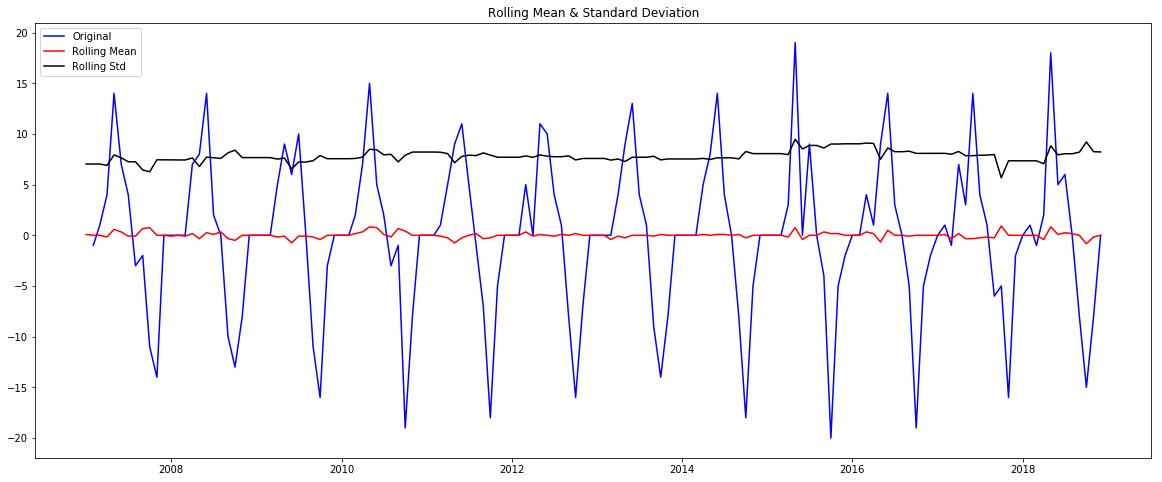

Results of Dickey-Fuller Test:
Test Statistic                -6.689512e+00
p-value                        4.143780e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.420000e+02
Critical Value (1%)           -3.477262e+00
Critical Value (5%)           -2.882118e+00
Critical Value (10%)          -2.577743e+00
dtype: float64


In [99]:
test_stationarity(diff_over70, 12)

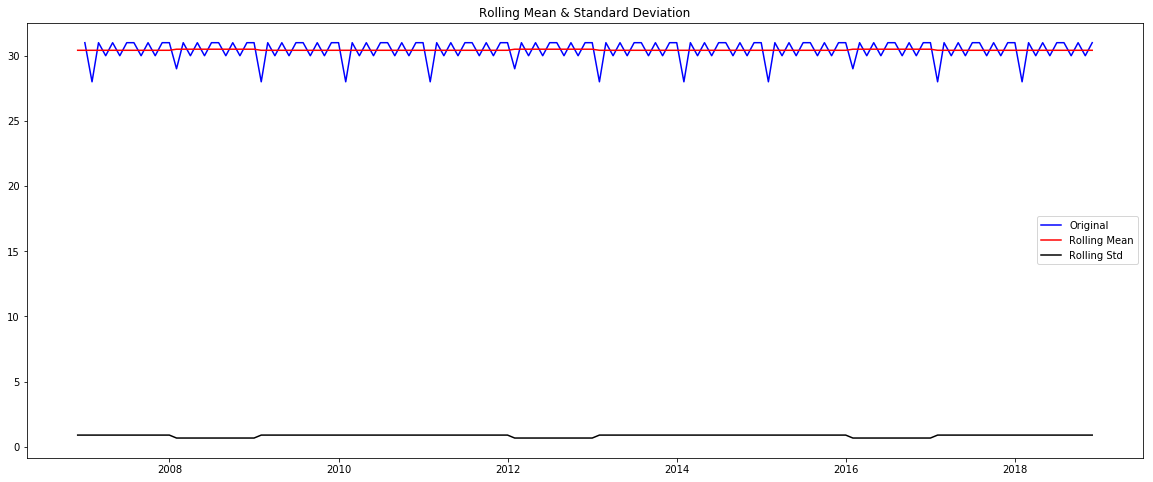

Results of Dickey-Fuller Test:
Test Statistic                  -2.809178
p-value                          0.056975
#Lags Used                      11.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [100]:
test_stationarity(completed_df.Days, 12)

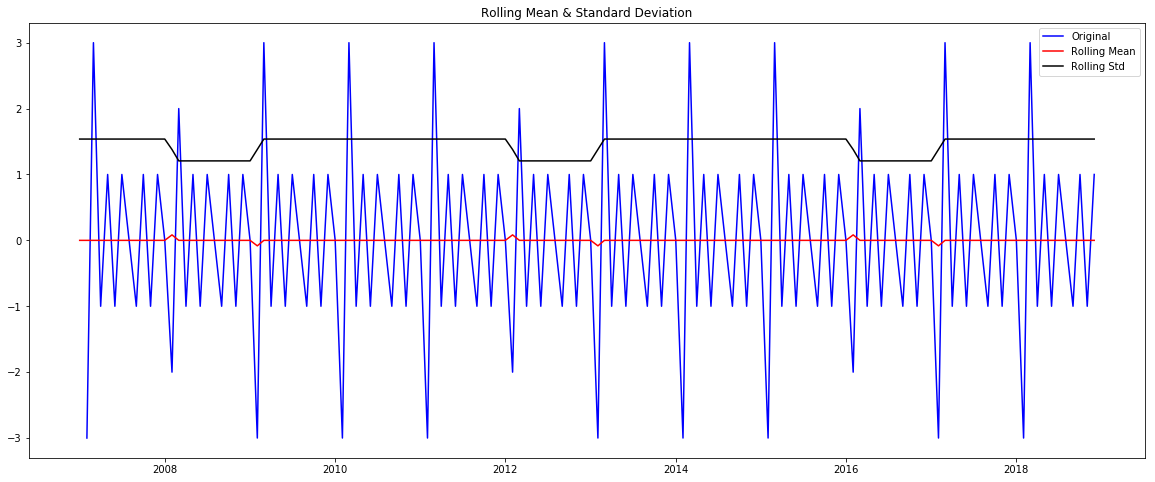

Results of Dickey-Fuller Test:
Test Statistic                 -31.795559
p-value                          0.000000
#Lags Used                      10.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [101]:
test_stationarity(diff_days, 12)